# London Weather & Electricity Demand Ingestion

**Goal:**  
1. Pull hourly weather (temperature & humidity) for London via Open-Meteo.  
2. Pull half-hourly GB demand via the National Grid ESO API.  
3. Save raw data as Parquet.  
4. Produce an initial exploratory plot.

> **Note:** Open-Meteo allows 10 Hz calls. National Grid ESO API allows 1 k calls/day.  
> We cache raw JSON in `data_raw/` to avoid re-hitting the APIs on notebook reruns.

**Author:** Alejandro Ito Aramendia <br>
**Date:** 08-07-2025

## Imports

In [26]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt

## Fetch London Weather via Open-Meteo  
Coordinates for London: 51.5074 N, -0.1278 W  
We use Open-Meteo’s free REST API for weather data (temperature and humidity) between the dates 2025/05/30 and 2025/07/01. 

In [27]:
lat, lon = 51.5074, -0.1278

start_date = "2025-05-30"
end_date = "2025-07-01"

open_meteo_url = (
    "https://archive-api.open-meteo.com/v1/archive"
    f"?latitude={lat}&longitude={lon}"
    f"&start_date={start_date}&end_date={end_date}"
    "&hourly=temperature_2m,relativehumidity_2m"
    "&timezone=Europe/London"
)
r = requests.get(open_meteo_url)
r.raise_for_status()
data = r.json()

df_weather = pd.DataFrame({
    "datetime": pd.to_datetime(data["hourly"]["time"]),
    "temperature_C": data["hourly"]["temperature_2m"],
    "humidity_pct": data["hourly"]["relativehumidity_2m"]
})

df_weather.head()

,datetime,temperature_C,humidity_pct
0,2025-05-30 00:00:00,16.5,85
1,2025-05-30 01:00:00,15.8,89
2,2025-05-30 02:00:00,15.2,91
3,2025-05-30 03:00:00,15.2,91
4,2025-05-30 04:00:00,15.2,90


**Sanity check:**  
- Weather DF shape: `(rows, 3)`  
- Any missing values?  

In [28]:
df_weather.info()
df_weather.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 792 entries, 0 to 791
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       792 non-null    datetime64[ns]
 1   temperature_C  792 non-null    float64       
 2   humidity_pct   792 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 18.7 KB


datetime         0
temperature_C    0
humidity_pct     0
dtype: int64

## Fetch GB Demand via National Grid ESO  
We’ll retrieve the last 10 000 half-hour records from the  
“Demand Forecast vs Outturn” datastore.

In [29]:
eso_url = "https://api.neso.energy/api/3/action/datastore_search"
params = {
    "resource_id": "177f6fa4-ae49-4182-81ea-0c6b35f26ca6",
    "limit": 10000
}
r = requests.get(eso_url, params=params)
r.raise_for_status()
data = r.json()
records = data["result"]["records"]
df_load = pd.DataFrame(records)

df_load.head()

,_id,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,FORECAST_ACTUAL_INDICATOR,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,...,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW,VIKING_FLOW,GREENLINK_FLOW
0,1,2025-06-01,1,19830,A,22938,18389,1947,6606,0,...,1355,992,-849,-37,0,-739,910,0,-575,397
1,2,2025-06-01,2,19384,A,22466,18059,1941,6606,0,...,1355,992,-850,0,0,-733,835,0,-591,397
2,3,2025-06-01,3,18781,A,22676,17610,1905,6606,0,...,1355,992,-995,56,0,-949,462,0,-1046,397
3,4,2025-06-01,4,18351,A,22289,17299,1869,6606,0,...,1356,992,-997,11,0,-957,386,0,-1078,397
4,5,2025-06-01,5,17881,A,21934,16912,2001,6606,0,...,1362,992,-1041,0,0,-1021,11,0,-1091,397


In [30]:
# Clean columns
df_load.columns = (
    df_load.columns
    .str.strip()
    .str.replace(' ', '_')
    .str.lower()
)

# Convert types and build datetime
df_load["settlement_period"] = df_load["settlement_period"].astype(int)
df_load["datetime"] = (
    pd.to_datetime(df_load["settlement_date"])
    + pd.to_timedelta((df_load["settlement_period"] - 1) * 30, unit="m")
)
df_load = df_load[["datetime", "nd"]].rename(columns={"nd": "demand_mw"})
df_load = df_load.sort_values("datetime")

df_load.head()

,datetime,demand_mw
0,2025-06-01 00:00:00,19830
1,2025-06-01 00:30:00,19384
2,2025-06-01 01:00:00,18781
3,2025-06-01 01:30:00,18351
4,2025-06-01 02:00:00,17881


## Save Raw Data to Parquet  
We’ll keep `data_raw/` for untouched pulls.

In [31]:
output_dir = "../data_raw"
os.makedirs(output_dir, exist_ok=True)

df_weather.to_parquet(os.path.join(output_dir, "weather.parquet"), index=False)
df_load.to_parquet(os.path.join(output_dir, "load.parquet"), index=False)

## Data Visualisation
Aligning half-hour GB demand with hourly London temperature.

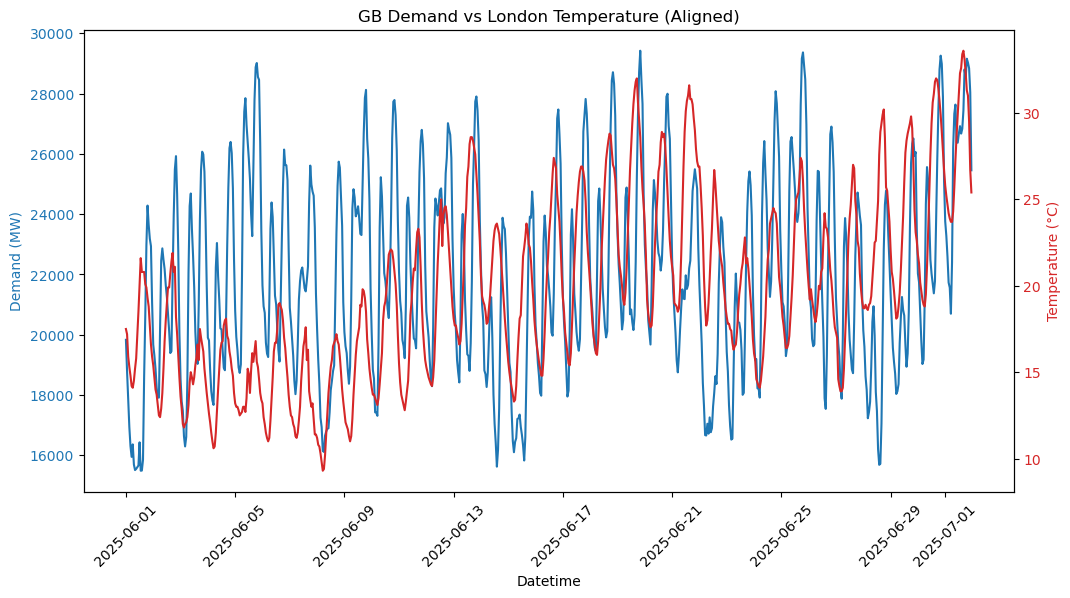

In [32]:
# Merge on common datetimes
df_merged = pd.merge(df_load, df_weather, on="datetime", how="inner")

fig, ax1 = plt.subplots(figsize=(12,6))
color = 'tab:blue'
ax1.set_xlabel('Datetime')
ax1.set_ylabel('Demand (MW)', color=color)
ax1.plot(df_merged["datetime"], df_merged["demand_mw"], color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', labelrotation=45)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Temperature (°C)', color=color)
ax2.plot(df_merged["datetime"], df_merged["temperature_C"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("GB Demand vs London Temperature (Aligned)")
plt.show()

## Next Steps  
- Align both series to a uniform hourly index and handle missing data.  
- Engineer seasonality features (hour of day, day of week, Fourier terms).  
- Build baseline ARIMA/Prophet forecasts.  

These can be found in the `02_data_cleaning_and_baselines` notebook.